In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [35]:
BATCH_SIZE = 500 # 大概需要2G的显存
EPOCHS = 10 # 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [36]:
# 训练集
train_set = datasets.MNIST('data', train = True, download = True,
                           transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1037,), (0.3081,))
                           ]))
train_loader = torch.utils.data.DataLoader(train_set,batch_size = BATCH_SIZE, shuffle = True)

# 测试集
test_set = datasets.MNIST('data', train = False, 
                          transform = transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1037,), (0.3081,))
                          ]))
test_loader = torch.utils.data.DataLoader(test_set,batch_size = BATCH_SIZE, shuffle = True)

In [37]:
# 定义模型
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        #1*1*28*28
        self.conv1 = nn.Conv2d(1, 10, 5) 
        self.conv2 = nn.Conv2d(10, 20, 3) 
        self.fc1 = nn.Linear(20 * 10 * 10, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        out= self.conv1(x) # 1* 10 * 24 *24
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2) # 1* 10 * 12 * 12
        out = self.conv2(out) # 1* 20 * 10 * 10
        out = F.relu(out)
        out = out.view(in_size, -1) # 1 * 2000
        out = self.fc1(out) # 1 * 500
        out = F.relu(out)
        out = self.fc2(out) # 1 * 10
        out = F.log_softmax(out, dim = 1)
        return out

In [38]:
#生成模型和优化器
model = ConvNet().to(DEVICE)
optimizer = optim.Adam(model.parameters())

In [39]:
# 定义训练函数
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = []
    train_acc = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim = True)[1] # 找到概率最大的下标
        train_acc += pred.eq(target.view_as(pred)).sum().item()
        
        if (batch_idx + 1) % 12 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_loss.append(loss.data.item())
        
    train_acc=train_acc/len(train_loader.dataset)    
    print('\nTrain Epoch: {}\tAccuracy:{:.4f}% '.format(epoch,100.*train_acc))
    return train_loss,100.*train_acc

In [40]:
# 定义测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss =0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction = 'sum') # 将一批的损失相加
            pred = output.max(1, keepdim = True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_acc= correct / len(test_loader.dataset)
    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%) \n".format(
        test_loss, correct, len(test_loader.dataset),100.* test_acc))
    return test_loss.item(),100.*test_acc

In [41]:
# 最后开始训练和测试
train_losses = []
train_acces = []
test_losses = []
test_acces = []

for epoch in range(1, EPOCHS + 1):
    tr_loss,tr_acc=train(model,  DEVICE, train_loader, optimizer, epoch)
    te_loss,te_acc=test(model, DEVICE, test_loader)
    for item in tr_loss:
        train_losses.append(item)
    train_acces.append(tr_acc)
    test_losses.append(te_loss)
    test_acces.append(te_acc)

Train Epoch: 1 [5500/60000 (9%)]	Loss: 0.554578
Train Epoch: 1 [11500/60000 (19%)]	Loss: 0.370902
Train Epoch: 1 [17500/60000 (29%)]	Loss: 0.331757
Train Epoch: 1 [23500/60000 (39%)]	Loss: 0.139449
Train Epoch: 1 [29500/60000 (49%)]	Loss: 0.164794
Train Epoch: 1 [35500/60000 (59%)]	Loss: 0.140562
Train Epoch: 1 [41500/60000 (69%)]	Loss: 0.122376
Train Epoch: 1 [47500/60000 (79%)]	Loss: 0.110330
Train Epoch: 1 [53500/60000 (89%)]	Loss: 0.120421
Train Epoch: 1 [59500/60000 (99%)]	Loss: 0.077994

Train Epoch: 1	Accuracy:91.7900% 

Test set: Average loss: 0.0838, Accuracy: 9737/10000 (97.3700%) 

Train Epoch: 2 [5500/60000 (9%)]	Loss: 0.094551
Train Epoch: 2 [11500/60000 (19%)]	Loss: 0.114807
Train Epoch: 2 [17500/60000 (29%)]	Loss: 0.085704
Train Epoch: 2 [23500/60000 (39%)]	Loss: 0.065286
Train Epoch: 2 [29500/60000 (49%)]	Loss: 0.072132
Train Epoch: 2 [35500/60000 (59%)]	Loss: 0.085817
Train Epoch: 2 [41500/60000 (69%)]	Loss: 0.058815
Train Epoch: 2 [47500/60000 (79%)]	Loss: 0.077025
Tr

In [9]:
def draw_plot(data,label,x,y):
    plt.plot(data,label=label)
    plt.xlabel(x, fontsize=14)
    plt.ylabel(y, fontsize=14)
    plt.legend()

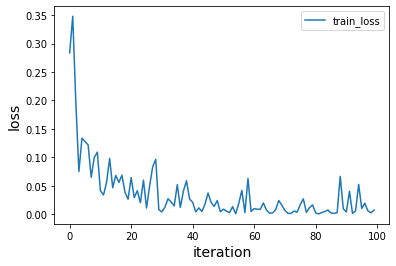

In [10]:
draw_plot(train_losses,"train_loss","iteration","loss")

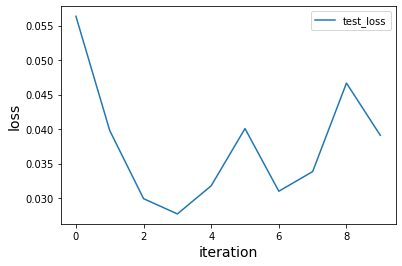

In [11]:
draw_plot(test_losses,"test_loss","iteration","loss")

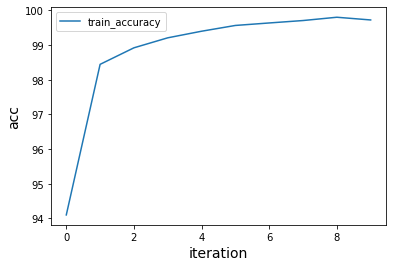

In [12]:
draw_plot(train_acces,"train_accuracy","iteration","acc")

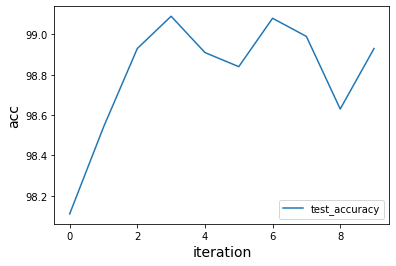

In [13]:
draw_plot(test_acces,"test_accuracy","iteration","acc")